In [452]:
import ee
import folium
import os
import pandas as pd
import foliumgee
import rasterio as rio
import numpy as np
from rasterio import plot

import datetime as dt

from sklearn import preprocessing

import matplotlib.pyplot as plt


In [151]:
#ee.Authenticate()
ee.Initialize()

### generate a list of EE dates to search for images

In [615]:
imdir = '/Users/corey/Documents/GitHub/jpl_msp_2020/data/ecostress_mt_rainier'
labelled = pd.read_csv(os.path.join(imdir, 'labelled_images_rainier.csv'))

qced = labelled[labelled['qc_flag'] ==True]

#Parse dates

doy = qced['images'].str.split('/').str[8].str.split('_').str[3].str.replace('doy', '')
doy = pd.to_datetime(doy, format='%Y%j%H%M%S')
qced['doy'] = doy.values
qced = qced.sort_values('doy')


doy = doy.sort_values()
days = doy.dt.day
months = doy.dt.month
years = doy.dt.year

hour = doy.dt.hour
minute = doy.dt.minute
second = doy.dt.second



#Format into list of ee.Date objects
ee_dates = []
for i, d in enumerate(days):
    date_str = str(years.iloc[i])+'-'+str(months.iloc[i])+'-'+str(days.iloc[i])+' '+str(hour.iloc[i])+' '+str(minute.iloc[i])+' '+str(second.iloc[i])
    ee_dates.append(ee.Date.parse('yyyy-MM-DD HH mm ss',date_str))

<ipython-input-615-556d656217e1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qced['doy'] = doy.values


### Define a search region and retrieve an image +-5 days of ECOSTRESS and append the least cloud obscured to a list

In [636]:
#Make cloud free mosaics of S2 Images

bands = ['B4', 'B3', 'B2']


region = ee.Geometry.Polygon([[[-121.91748046875, 46.763085924088955],
      [-121.91748046875, 47.020166002213955],
      [-121.568115234375, 47.020166002213955],
      [-121.568115234375, 46.763085924088955],
      [-121.91748046875, 46.763085924088955]]])

#make a list of months for image mosaic creation
months = pd.date_range('2019-06-01', '2020-07-01', 12)

def maskclouds(image):
        band_qa = image.select('QA60')
        cloud_mask = ee.Number(2).pow(10).int()
        cirrus_mask = ee.Number(2).pow(11).int()
        mask = band_qa.bitwiseAnd(cloud_mask).eq(0) and(
            band_qa.bitwiseAnd(cirrus_mask).eq(0))
        return image.updateMask(mask).divide(10000).clip(region) #.set('id', image.get('id').getInfo())



#Iterate over list of date and 

#find images acquiered within 5 days on either side
#and choose the one with the least couldy pixel percentage

s2 = ee.ImageCollection("COPERNICUS/S2_SR")

s2_ims = []

for d in months:
    end = ee.Date(d + dt.timedelta(weeks=4))
    d = ee.Date(d)
    im = s2.filterBounds(region).filterDate(d, end).map(maskclouds)
    s2_ims.append(im.select(bands).min().set('ecostress_date', d.format().getInfo()))

    
    

In [637]:
months

DatetimeIndex(['2019-06-01', '2019-07-07', '2019-08-12', '2019-09-17',
               '2019-10-23', '2019-11-28', '2020-01-03', '2020-02-08',
               '2020-03-15', '2020-04-20', '2020-05-26', '2020-07-01'],
              dtype='datetime64[ns]', freq=None)

In [641]:
qced[(qced['doy'] >= months[0]) & (qced['doy'] <= months[1])]

,Unnamed: 0,images,qc_flag,doy
9,9,/Users/corey/Documents/GitHub/jpl_msp_2020/dat...,True,2019-06-03 00:11:13
13,13,/Users/corey/Documents/GitHub/jpl_msp_2020/dat...,True,2019-06-03 23:22:22
47,47,/Users/corey/Documents/GitHub/jpl_msp_2020/dat...,True,2019-06-10 20:49:24
1,1,/Users/corey/Documents/GitHub/jpl_msp_2020/dat...,True,2019-06-13 19:57:07
22,22,/Users/corey/Documents/GitHub/jpl_msp_2020/dat...,True,2019-06-17 18:16:12


### Export images to drive

In [433]:
for i in s2_ims:
    task_config = {
    'scale': 10,  
    'region': region,
    'folder': 'sentinel_2_rainier'
    }
    task = ee.batch.Export.image(i, str(i.get('ecostress_date').getInfo()), task_config)
    task.start()


In [695]:
band5_r

array([[[0.94 , 0.95 , 0.944, ..., 0.958, 0.958, 0.96 ],
        [0.952, 0.952, 0.934, ..., 0.972, 0.956, 0.956],
        [0.948, 0.942, 0.966, ..., 0.972, 0.966, 0.972],
        ...,
        [0.94 , 0.94 , 0.94 , ..., 0.974, 0.974, 0.97 ],
        [0.956, 0.956, 0.944, ..., 0.97 , 0.976, 0.968],
        [0.958, 0.946, 0.946, ..., 0.962, 0.958, 0.958]]])

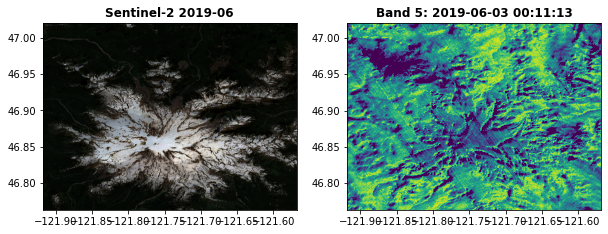

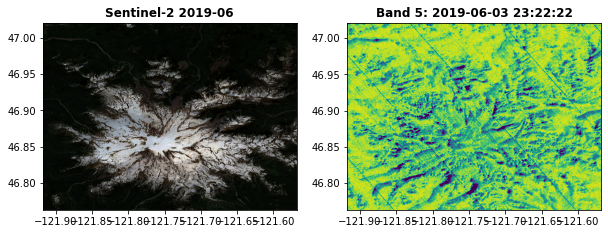

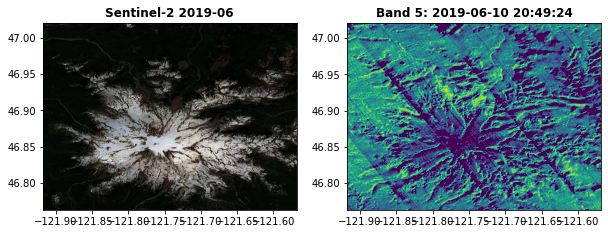

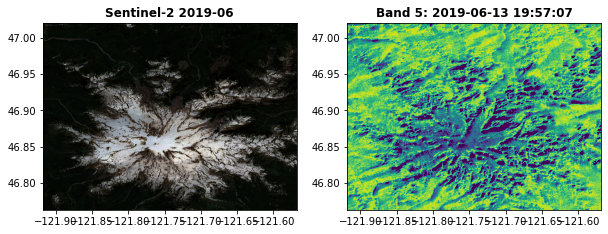

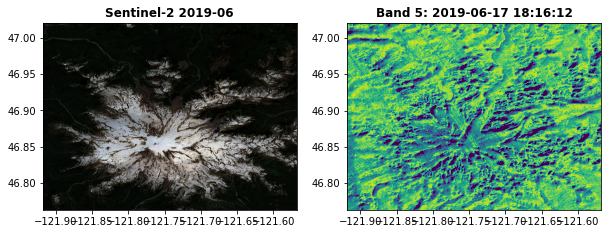

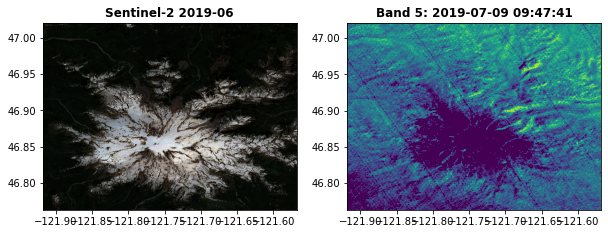

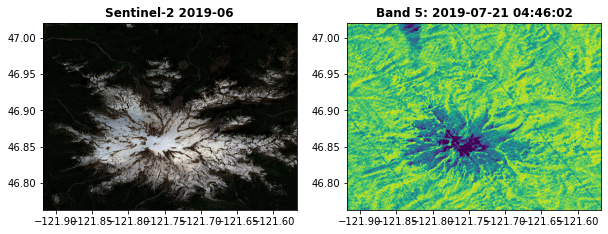

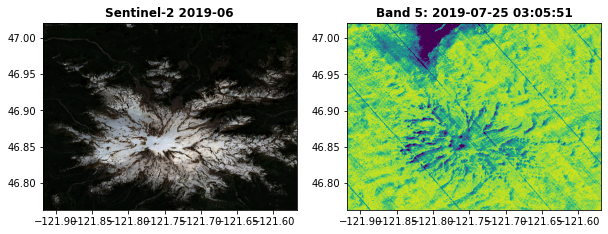

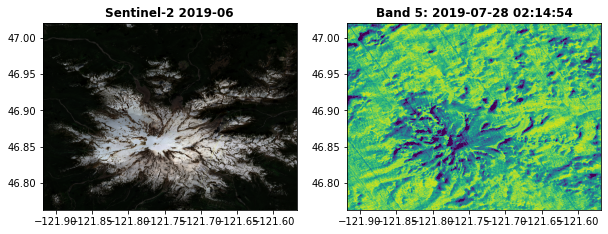

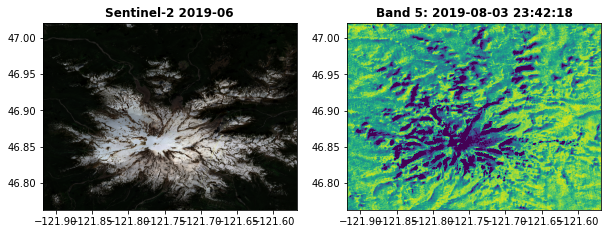

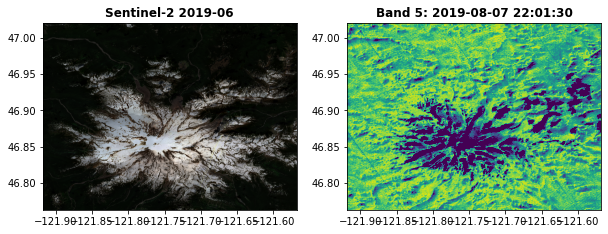

In [ ]:
#Import and plot the images

def normalize(x):
    return ((x - np.nanmin(x)) * (1/(np.nanmax(x) - np.nanmin(x)) * 255)).astype('uint8')

s2_imdir = '/Users/corey/Google Drive/sentinel_2_rainier'

for f, s, d in os.walk(s2_imdir):
    d = sorted(d)
    for idx, i in enumerate(d):
        if '.tif' in i:
            path =  os.path.join(s2_imdir, i)
            img = rio.open(path)
        # normalize
            bands = {}

            for b in [1,2,3]:
                band = np.nan_to_num(img.read(b))
                bands["band{0}".format(b)] = normalize(band) # preprocessing.normalize(i,'l1', axis=0)
            rgb = np.stack([bands['band1'], bands['band2'], bands['band3']])
# Get a list of the ECOSTRESS images in this month

            d = i.replace('.tif', '').split('T')[0]
            try:
                eco_ims = qced[(qced['doy'] >= months[idx-1]) & (qced['doy'] < months[idx+1])]
                for image in eco_ims.iterrows():
                    band5 = rio.open(image[1]['images'])

                    band5_r = band5.read()*0.002+0.49
                    #lst = 
                    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
                    plot.show(rgb, transform = img.transform, title='Sentinel-2 '+str(i)[:7], ax=ax[0])
                    plot.show(band5_r, ax=ax[1], cmap="viridis", title='Band 5: '+str(image[1]['doy']), vmin=0.9, vmax=0.99, transform=band5.transform)
                    plt.show()
            except:
                pass
#        plt.title(str(i) +' mosaic')

In [654]:
image[1]['images']

'/Users/corey/Documents/GitHub/jpl_msp_2020/data/ecostress_mt_rainier/ECO2LSTE.001_SDS_Emis5_doy2019190094741_aid0001.tif'

### These are all mapping endeavours below

In [ ]:
ee.Initialize()

#@title Mapdisplay: Display GEE objects using folium.
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

In [137]:
# Define a method for displaying Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [147]:
# can only look at 10 images at a time so do it in chunks of 20

center = [46.83193588256836, -121.78742980957031]

m = folium.Map(location=center, zoom_start=8, tiles='Stamen Terrain')

vis = {'min': 500, 'max': 7500}


#for i in s2_ims[:4]:
#date = i.date().format().getInfo()


m.add_ee_layer(s2_ims[0].select(['B5', 'B3', 'B2']),vis, s2_ims[0].date().format().getInfo())
m.add_ee_layer(s2_ims[1].select(['B5', 'B3', 'B2']),vis, s2_ims[1].date().format().getInfo())
m.add_ee_layer(s2_ims[2].select(['B5', 'B3', 'B2']),vis, s2_ims[2].date().format().getInfo())
m.add_ee_layer(s2_ims[3].select(['B5', 'B3', 'B2']),vis, s2_ims[3].date().format().getInfo())
m.add_ee_layer(s2_ims[4].select(['B5', 'B3', 'B2']),vis, s2_ims[4].date().format().getInfo())

m.add_child(folium.LayerControl())
display(m)

In [136]:
# Load an image.
image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318')

# Create an NDWI image, define visualization parameters and display.
ndwi = image.normalizedDifference(['B3', 'B5'])

# Mask the non-watery parts of the image, where NDWI < 0.4.
ndwiMasked = ndwi.updateMask(ndwi.gte(0.4))
ndwiId = ndwiMasked.getMapId({'min': 0.5, 'max': 1, 'palette': ['00FFFF', '0000FF']})

# Display the map with folium!
center=[38., -122.5]
Mapdisplay(center,{'NDWI masked':ndwiId})




In [78]:
ee_dates[0].format().getInfo()

'2019-06-13T00:00:00'

In [95]:
s2_ims[0].date().format().getInfo()

'2019-06-15T19:21:40'

In [125]:
foliumgee.layer?